# Packages

In [132]:
import glob
import string

from multiprocessing import Pool

from pyhvr import *
loadstd()

In [2]:
def pearson(data):
    """
    Calculates the Pearson correlation coefficient.
    Parameters
    ----------
    data: two-columns numpy array
    ----------
    Returns Pearson.
    """
    data=data.transpose()
    pea=scipy.stats.pearsonr(data[0],data[1])
    return(pea)

def spearman(data):
    """
    Calculates the Pearson correlation coefficient.
    Parameters
    ----------
    data: two-columns numpy array
    ----------
    Returns Pearson.
    """
    data=data.transpose()
    pea=scipy.stats.spearmanr(data[0],data[1])
    return(pea)

In [152]:
# df = north_america_overlay_5050
def spearman_symp(df, order, perc_filter=0.3):
    # columns to use
    cols = ['area1', 'area2']
    if order == 'greater':
        df_size = pd.DataFrame([df[df['symp'] >= 1-s].shape[0] for s in np.arange(0, 1.1, 0.1)], columns=['size'])
        df_perc = pd.DataFrame([df[df['symp'] >= 1-s].shape[0]/df.shape[0] for s in np.arange(0, 1.1, 0.1)], columns=['perc'])
        df_spea = pd.DataFrame([np.asarray(spearman(np.asarray(df[df['symp'] >= 1-s][cols].apply(np.log)))) for s in np.arange(0, 1.1, 0.1)], columns=['spearman', 'pvalue'], index=np.arange(0,110,10)/100).reset_index()
        df = pd.concat([df_spea, df_size, df_perc], axis=1).dropna()
        df = df[df['perc'] >= perc_filter]
    elif order == 'less':
        df_size = pd.DataFrame([df[df['symp'] <= s].shape[0] for s in np.arange(0, 1.1, 0.1)], columns=['size'])
        df_perc = pd.DataFrame([df[df['symp'] <= s].shape[0]/df.shape[0] for s in np.arange(0, 1.1, 0.1)], columns=['perc'])
        df_spea = pd.DataFrame([np.asarray(spearman(np.asarray(df[df['symp'] <= s][cols].apply(np.log)))) for s in np.arange(0, 1.1, 0.1)], columns=['spearman', 'pvalue'], index=np.arange(0,110,10)/100).reset_index()
        df = pd.concat([df_spea, df_size, df_perc], axis=1).dropna()
        df = df[df['perc'] >= perc_filter]
    else:
        raise ValueError('unknown order value: {}'.format(order))
        
    return df

In [15]:
# df = north_america_overlay_5050
def spearman_sympatry(df, order, perc_filter=0.3, resample=False, rep=1000, alpha=0.05):
    # columns to use
    cols = ['area1', 'area2']
    if order == 'greater':
        df_size = pd.DataFrame([df[df['symp'] >= 1-s].shape[0] for s in np.arange(0, 1.1, 0.1)], columns=['size'])
        df_perc = pd.DataFrame([df[df['symp'] >= 1-s].shape[0]/df.shape[0] for s in np.arange(0, 1.1, 0.1)], columns=['perc'])
        df_spea = pd.DataFrame([np.asarray(spearman(np.asarray(df[df['symp'] >= 1-s][cols].apply(np.log)))) for s in np.arange(0, 1.1, 0.1)], columns=['spearman', 'pvalue'], index=np.arange(0,110,10)/100).reset_index()
                
        # condition if one wants to resample each pair within the df
        if resample:
            # list to append the mean spearman coefficient and the confidence interval values
            stats_l = []
            # loop through the sympatry values to filter the df
            for s in np.arange(0, 1.1, 0.1):
                # create a temporary array with the values of area1 and area2
                arr_tmp = np.asarray(df[df['symp'] >= 1-s][cols].apply(np.log))
                # list to append the values of the spearman coefficient for the resampled df
                spear_l = []
                # loop to shuffle each pair
                for _ in range(rep):
                    # shuffling each pair
                    [np.random.shuffle(arr) for arr in arr_tmp]
                    # append the spearman coefficient to the previous created list
                    spear_l.append(spearman(arr_tmp)[0])

                # transform the spearman coefficients list into an array
                spear_arr = np.asarray(spear_l)

                # calculate the mean value of all spearman coefficients and the confidence interval [5, 95]
                stats_values = np.append(spear_arr.mean(), np.percentile(spear_arr, q=[100*alpha/2, 100*(1-alpha/2)]))
                
                # append the stats values to the stats list
                stats_l.append(stats_values)
            
            df_stats = pd.DataFrame(stats_l, columns=['spearman_mean', 'spearman_5CI', 'spearman_95CI'])
            
            df = pd.concat([df_spea, df_size, df_perc, df_stats], axis=1).dropna()
            df = df[df['perc'] >= perc_filter]
          
        else:
            
            df = pd.concat([df_spea, df_size, df_perc], axis=1).dropna()
            df = df[df['perc'] >= perc_filter]
        
    elif order == 'less':
        df_size = pd.DataFrame([df[df['symp'] <= s].shape[0] for s in np.arange(0, 1.1, 0.1)], columns=['size'])
        df_perc = pd.DataFrame([df[df['symp'] <= s].shape[0]/df.shape[0] for s in np.arange(0, 1.1, 0.1)], columns=['perc'])
        df_spea = pd.DataFrame([np.asarray(spearman(np.asarray(df[df['symp'] <= s][cols].apply(np.log)))) for s in np.arange(0, 1.1, 0.1)], columns=['spearman', 'pvalue'], index=np.arange(0,110,10)/100).reset_index()
        
          # condition if one wants to resample each pair within the df
        if resample:
            # list to append the mean spearman coefficient and the confidence interval values
            stats_l = []
            # loop through the sympatry values to filter the df
            for s in np.arange(0, 1.1, 0.1):
                # create a temporary array with the values of area1 and area2
                arr_tmp = np.asarray(df[df['symp'] <= s][cols].apply(np.log))
                # list to append the values of the spearman coefficient for the resampled df
                spear_l = []
                # loop to shuffle each pair
                for _ in range(rep):
                    # shuffling each pair
                    [np.random.shuffle(arr) for arr in arr_tmp]
                    # append the spearman coefficient to the previous created list
                    spear_l.append(spearman(arr_tmp)[0])

                # transform the spearman coefficients list into an array
                spear_arr = np.asarray(spear_l)

                # calculate the mean value of all spearman coefficients and the confidence interval [5, 95]
                stats_values = np.append(spear_arr.mean(), np.percentile(spear_arr, q=[100*alpha/2, 100*(1-alpha/2)]))
                
                # append the stats values to the stats list
                stats_l.append(stats_values)
            
            df_stats = pd.DataFrame(stats_l, columns=['spearman_mean', 'spearman_5CI', 'spearman_95CI'])
            
            df = pd.concat([df_spea, df_size, df_perc, df_stats], axis=1).dropna()
            df = df[df['perc'] >= perc_filter]
            
        else:
            df = pd.concat([df_spea, df_size, df_perc], axis=1).dropna()
            df = df[df['perc'] >= perc_filter]
            
    else:
        raise ValueError('unknown order value: {}'.format(order))
        
    return df

# Europe

In [172]:
# nmf - null model files
nmf_europe = glob.glob('null_model_results/n157*')

In [63]:
nm_spearman_europe_gs = pd.DataFrame({'dummy': np.arange(1, 11)}).set_index('dummy')
nm_spearman_europe_ls = pd.DataFrame({'dummy': np.arange(1, 11)}).set_index('dummy')

for i in range(len(nmf_europe)):
    # load the pd.DataFrame
    df = pd.read_table(nmf_europe[i])
    
    # calculate the spearman per sympatry interval
    df_gs = spearman_symp(df, order='greater')
    df_ls = spearman_symp(df, order='less')
    
    # append to the final pd.DataFrame
    nm_spearman_europe_gs['spearman_{}'.format(i)] = t.index.map(df_gs['spearman'])
    nm_spearman_europe_ls['spearman_{}'.format(i)] = t.index.map(df_ls['spearman'])

NameError: name 'spearman_symp' is not defined

In [175]:
nm_spearman_europe_gs = pd.DataFrame({'dummy': np.arange(1, 11)}).set_index('dummy')
nm_spearman_europe_ls = pd.DataFrame({'dummy': np.arange(1, 11)}).set_index('dummy')

for i in range(len(nmf_europe)):
    # load the pd.DataFrame
    df = pd.read_table(nmf_europe[i])
    
    # calculate the spearman per sympatry interval with resample
    df_gs = spearman_sympatry(df, order='greater', resample=True)
    df_ls = spearman_sympatry(df, order='less', resample=True)
    
    # append to the final pd.DataFrame
    nm_spearman_europe_gs['spearman_{}'.format(i)] = df_gs['spearman']
    nm_spearman_europe_ls['spearman_{}'.format(i)] = df_ls['spearman']
    
    nm_spearman_europe_gs['spearman_mean_{}'.format(i)] = df_gs['spearman_mean']
    nm_spearman_europe_ls['spearman_mean_{}'.format(i)] = df_ls['spearman_mean']
    
#     nm_spearman_europe_gs['spearman_5CI_{}'.format(i)] = df_gs['spearman_5CI']
#     nm_spearman_europe_ls['spearman_5CI_{}'.format(i)] = df_ls['spearman_5CI']
    
#     nm_spearman_europe_gs['spearman_95CI_{}'.format(i)] = df_gs['spearman_95CI']
#     nm_spearman_europe_ls['spearman_95CI_{}'.format(i)] = df_ls['spearman_95CI']

/home/dsvieira/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [183]:
nm_spearman_europe_gs = nm_spearman_europe_gs.fillna(0)
nm_spearman_europe_ls = nm_spearman_europe_ls.fillna(0)

In [181]:
# nm_spearman_europe_gs.to_csv('nm_spearman_europe_gs.dat', index=False, sep='\t')
# nm_spearman_europe_ls.to_csv('nm_spearman_europe_ls.dat', index=False, sep='\t')

# North America

In [58]:
# nmf - null model files
nmf_north_america = glob.glob('null_model_results/n216*')

In [82]:
nm_spearman_north_america_gs = pd.DataFrame({'dummy': np.arange(1, 11)}).set_index('dummy')
nm_spearman_north_america_ls = pd.DataFrame({'dummy': np.arange(1, 11)}).set_index('dummy')

for i in range(len(nmf_north_america)):
    # load the pd.DataFrame
    df = pd.read_table(nmf_north_america[i])
    
    # calculate the spearman per sympatry interval
    df_gs = spearman_symp(df, order='greater')
    df_ls = spearman_symp(df, order='less')
    
    # append to the final pd.DataFrame
    nm_spearman_north_america_gs['spearman_{}'.format(i)] = t.index.map(df_gs['spearman'])
    nm_spearman_north_america_ls['spearman_{}'.format(i)] = t.index.map(df_ls['spearman'])

In [ ]:
def nm_pearson_mt_north_america(i):
    """
    nm - null model
    pearson
    mt - multiprocessing
    """
    
    df = pd.read_table(nmf_north_america[i])
    
    # calculate the spearman per sympatry interval with resample
    df_gs = spearman_sympatry(df, order='greater', resample=True)
    df_ls = spearman_sympatry(df, order='less', resample=True)

    # append to the final pd.DataFrame
    nm_spearman_north_america_gs['spearman_{}'.format(i)] = df_gs['spearman']
    nm_spearman_north_america_ls['spearman_{}'.format(i)] = df_ls['spearman']

    nm_spearman_north_america_gs['spearman_mean_{}'.format(i)] = df_gs['spearman_mean']
    nm_spearman_north_america_ls['spearman_mean_{}'.format(i)] = df_ls['spearman_mean']

#     nm_spearman_north_america_gs['spearman_5CI_{}'.format(i)] = df_gs['spearman_5CI']
#     nm_spearman_north_america_ls['spearman_5CI_{}'.format(i)] = df_ls['spearman_5CI']

#     nm_spearman_north_america_gs['spearman_95CI_{}'.format(i)] = df_gs['spearman_95CI']
#     nm_spearman_north_america_ls['spearman_95CI_{}'.format(i)] = df_ls['spearman_95CI']
    
    return nm_spearman_north_america_gs, nm_spearman_north_america_ls

In [178]:
nm_spearman_north_america_gs = pd.DataFrame({'dummy': np.arange(1, 11)}).set_index('dummy')
nm_spearman_north_america_ls = pd.DataFrame({'dummy': np.arange(1, 11)}).set_index('dummy')

for i in range(len(nmf_north_america)):
    # load the pd.DataFrame
    df = pd.read_table(nmf_north_america[i])
    
    # calculate the spearman per sympatry interval with resample
    df_gs = spearman_sympatry(df, order='greater', resample=True)
    df_ls = spearman_sympatry(df, order='less', resample=True)
    
    # append to the final pd.DataFrame
    nm_spearman_north_america_gs['spearman_{}'.format(i)] = df_gs['spearman']
    nm_spearman_north_america_ls['spearman_{}'.format(i)] = df_ls['spearman']
    
    nm_spearman_north_america_gs['spearman_mean_{}'.format(i)] = df_gs['spearman_mean']
    nm_spearman_north_america_ls['spearman_mean_{}'.format(i)] = df_ls['spearman_mean']
    
#     nm_spearman_north_america_gs['spearman_5CI_{}'.format(i)] = df_gs['spearman_5CI']
#     nm_spearman_north_america_ls['spearman_5CI_{}'.format(i)] = df_ls['spearman_5CI']
    
#     nm_spearman_north_america_gs['spearman_95CI_{}'.format(i)] = df_gs['spearman_95CI']
#     nm_spearman_north_america_ls['spearman_95CI_{}'.format(i)] = df_ls['spearman_95CI']

/home/dsvieira/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [184]:
nm_spearman_north_america_gs = nm_spearman_north_america_gs.fillna(0)
nm_spearman_north_america_ls = nm_spearman_north_america_ls.fillna(0)

In [180]:
# nm_spearman_north_america_gs.to_csv('nm_spearman_north_america_gs.dat', index=False, sep='\t')
# nm_spearman_north_america_ls.to_csv('nm_spearman_north_america_ls.dat', index=False, sep='\t')

# Figure null_model

In [602]:
# df = nm_spearman_europe
def tp_err(df):
    x = df.index/10
    y = df.mean(axis=1)
    yerr = df.std(axis=1)
    
    return x, y, yerr

In [609]:
tp_err(nm_spearman_europe_gs[nm_spearman_europe_gs.columns[nm_spearman_europe_gs.columns.str.contains('mean')]])[0]

Float64Index([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], dtype='float64', name='dummy')

/home/dsvieira/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


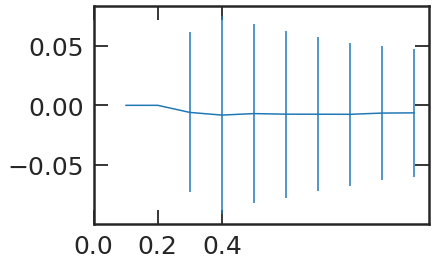

In [608]:
fig, ax = plt.subplots()

ax.errorbar(*tp_err(nm_spearman_europe_gs[nm_spearman_europe_gs.columns[nm_spearman_europe_gs.columns.str.contains('mean')]]))
ax.set_xticks([0,0.2,0.4])

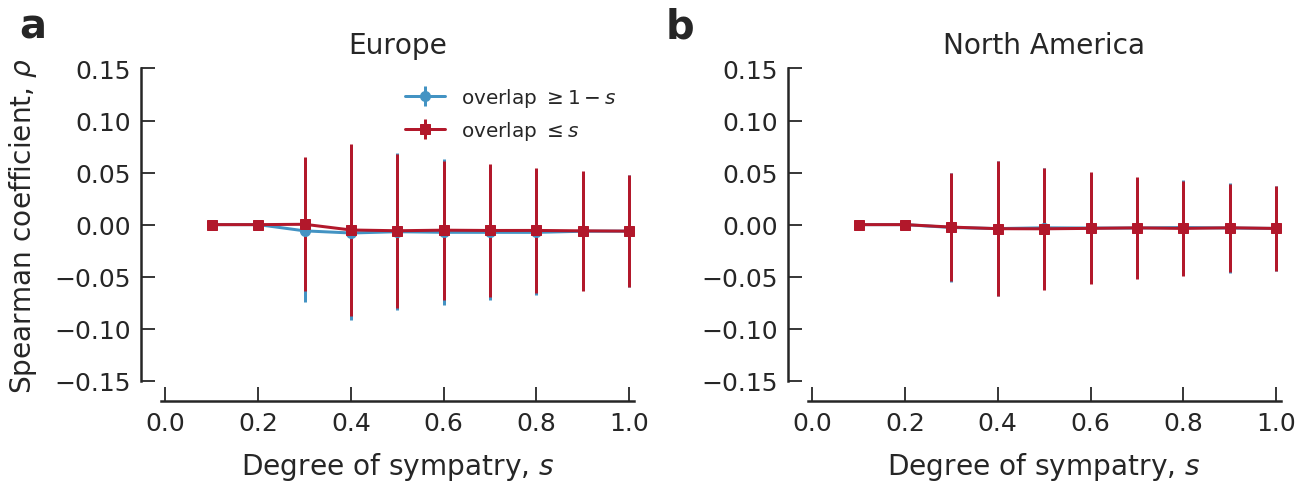

In [101]:
fig, ax = plt.subplots(1, 2, figsize=stdfigsize(ny=1, nx=2))

color_s = palettable.colorbrewer.diverging.RdBu_11_r.mpl_colors
kwargs_gs = dict(lw=3, marker='o', markersize=10, color=color_s[2])#, legend=False)
kwargs_ls = dict(lw=3, marker='s', markersize=10, color=color_s[-2])#, legend=False)

ax[0].errorbar(*tp_err(nm_spearman_europe_gs), **kwargs_gs)
ax[0].errorbar(*tp_err(nm_spearman_europe_ls), **kwargs_ls)

ax[1].errorbar(*tp_err(nm_spearman_north_america_gs), **kwargs_gs)
ax[1].errorbar(*tp_err(nm_spearman_north_america_ls), **kwargs_ls)

c = 0
for ax in ax.flat:
    ax.annotate(string.ascii_lowercase[c], xy=(-0.3, 1.1), xycoords='axes fraction', fontsize=40, weight='bold')
    
    for loc, spine in ax.spines.items():
        if loc in ['left', 'bottom']:
            spine.set_position(('outward', 20)) # outward by 20 points
        elif loc in ['right','top']:
            spine.set_color('none') # don't draw spine
        else:
            raise ValueError('unknown spine location: %s'%loc)
    
    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    if c == 0:
        ax.legend(['overlap $\\geq 1-s$', 'overlap $\\leq s$'], fontsize=20, frameon=False)
        ax.set_ylabel('Spearman coefficient, $\\rho$')
        
    ax.set_xlabel('Degree of sympatry, $s$')
    ax.set_title(['Europe', 'North America'][c])
    
    ax.set_ylim(-0.15, 0.15)
    ax.set_xlim([-0.01,1.01])
    ax.set_xticks(np.arange(0,1.2,0.2))
    
    c += 1
    
fig.tight_layout(w_pad=2)
fig.savefig('figures/nm_range_corr.pdf', bbox_inches='tight')
fig.savefig('figures/nm_range_corr.png', bbox_inches='tight')

In [226]:
# df = nm_spearman_europe_gs
def mean_band(df):
    _df = df[df.columns[df.columns.str.contains('mean')]]
    mean = _df.mean(axis=1)
    percentiles = np.asarray([np.percentile(_df.iloc[i], q=[5, 95]) for i in range(10)]).T

    return pd.DataFrame(data=np.asarray([mean, *percentiles]).T, columns=['mean', 'CI_5', 'CI_95']).set_index(np.arange(1,11)/10).reset_index()

/home/dsvieira/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


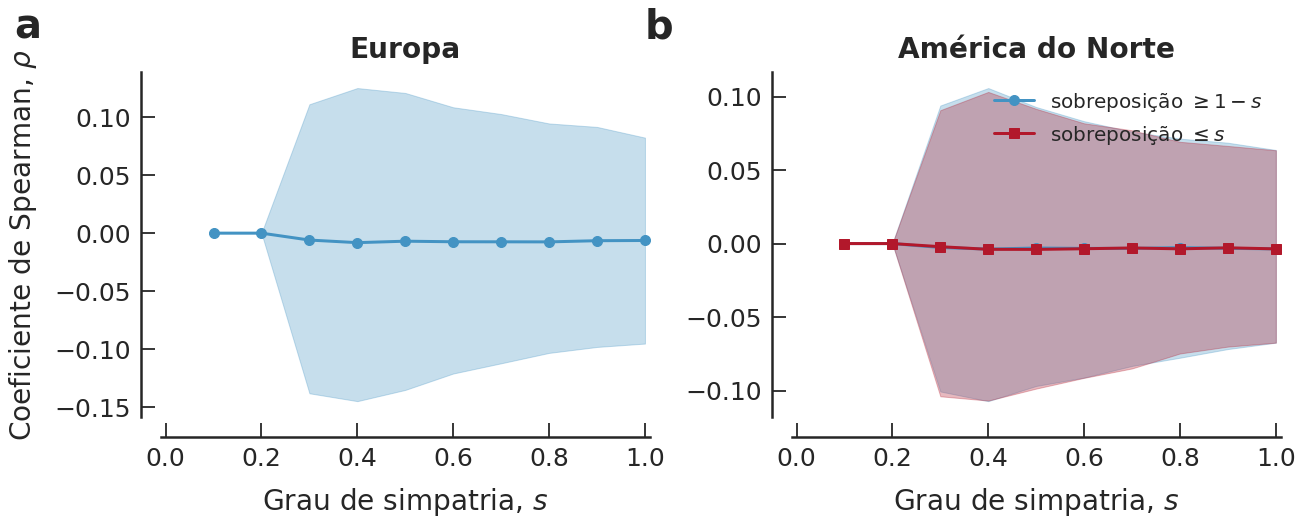

In [443]:
fig, ax = plt.subplots(1, 2, figsize=stdfigsize(ny=1, nx=2))

color_s = palettable.colorbrewer.diverging.RdBu_11_r.mpl_colors
kwargs_gs = dict(lw=3, marker='o', markersize=10, color=color_s[2])
kwargs_ls = dict(lw=3, marker='s', markersize=10, color=color_s[-2])

df = violin_data(nm_spearman_europe_gs, order='greater', country='Europe')
# sns.pointplot(x="symp", y="mean", data=df, capsize=.2)

mean_band(nm_spearman_europe_gs).plot('index', 'mean', ax=ax[0], **kwargs_gs, legend=False)
ax[0].fill_between(x='index', y1='CI_5', y2='CI_95', data=mean_band(nm_spearman_europe_gs), color=color_s[2], alpha=0.3)
# ax[0].errorbar(x='index', y='mean', yerr=np.asarray(mean_band(nm_spearman_europe_gs)[['CI_5', 'CI_5']]).T, data=mean_band(nm_spearman_europe_gs))
# sns.pointplot(x="symp", y="mean", data=df, capsize=.2, ax=ax[0])

# mean_band(nm_spearman_europe_ls).plot('index', 'mean', ax=ax[0], **kwargs_ls, legend=False)
# ax[0].fill_between(x='index', y1='CI_5', y2='CI_95', data=mean_band(nm_spearman_europe_ls), color=color_s[-2], alpha=0.3)

mean_band(nm_spearman_north_america_gs).plot('index', 'mean', ax=ax[1], **kwargs_gs)
ax[1].fill_between(x='index', y1='CI_5', y2='CI_95', data=mean_band(nm_spearman_north_america_gs), color=color_s[2], alpha=0.3)

mean_band(nm_spearman_north_america_ls).plot('index', 'mean', ax=ax[1], **kwargs_ls)
ax[1].fill_between(x='index', y1='CI_5', y2='CI_95', data=mean_band(nm_spearman_north_america_ls), color=color_s[-2], alpha=0.3)

c = 0
for ax in ax.flat:
    ax.annotate(string.ascii_lowercase[c], xy=(-0.3, 1.1), xycoords='axes fraction', fontsize=40, weight='bold')
    
    for loc, spine in ax.spines.items():
        if loc in ['left', 'bottom']:
            spine.set_position(('outward', 20)) # outward by 20 points
        elif loc in ['right','top']:
            spine.set_color('none') # don't draw spine
        else:
            raise ValueError('unknown spine location: %s'%loc)
    
    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    if c == 0:
#         ax.set_ylabel('Spearman coefficient, $\\rho$')
        ax.set_ylabel('Coeficiente de Spearman, $\\rho$') # PT
        
    elif c == 1:
#         ax.legend(['overlap $\\geq 1-s$', 'overlap $\\leq s$'], fontsize=20, frameon=False)
        ax.legend(['sobreposição $\\geq 1-s$', 'sobreposição $\\leq s$'], fontsize=20, frameon=False) # PT
        
#     ax.set_xlabel('Degree of sympatry, $s$')
#     ax.set_title(['Europe', 'North America'][c])
    ax.set_xlabel('Grau de simpatria, $s$') # PT
    ax.set_title(['Europa', 'América do Norte'][c], weight='bold') # PT
    
#     ax.set_ylim(-0.20, 0.20)
    ax.set_xlim([-0.01,1.01])
    ax.set_xticks(np.arange(0,1.2,0.2))
    
    c += 1
    
fig.tight_layout(w_pad=2)
# fig.savefig('figures/nm_range_corr_shuffle_band.pdf', bbox_inches='tight')
# fig.savefig('figures/nm_range_corr_shuffle_band.png', bbox_inches='tight')
fig.savefig('figures/nm_range_corr_shuffle_band_pt.pdf', bbox_inches='tight') # PT 

In [592]:
order = 'greater'
country = 'Europe'

def violin_data(df, order, country, lang='en'):

    df_l = []

    for i in range(10):
        _mean_s    = df[df.columns[df.columns.str.contains('mean')]].iloc[i].reset_index(drop=True)
        _symp_s    = pd.DataFrame(data=np.asarray(np.zeros(1001) + (i+1)/10))[0]
        _order_s   = pd.DataFrame(data=[order for _ in range(_symp_s.shape[0])])[0]
        _country_s = pd.DataFrame(data=[country for _ in range(_symp_s.shape[0])])[0]
        
        if lang == 'en':
            _df = pd.DataFrame(data=np.asarray([_mean_s, _symp_s, _order_s, _country_s]).T, columns=['mean', 'symp', 'overlapping', 'country'])
        elif lang == 'pt':
            _df = pd.DataFrame(data=np.asarray([_mean_s, _symp_s, _order_s, _country_s]).T, columns=['mean', 'symp', 'sobreposição', 'country'])
        else:
            raise ValueError("`{}` is not a appropriate lang value.".format(lang))
                

        df_l.append(_df)
        
        f = pd.concat(df_l).reset_index(drop=True)
        f['mean'] = f['mean'].astype(np.float)
        
        
    return f

In [550]:
df['symp'].unique()

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], dtype=object)

/home/dsvieira/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


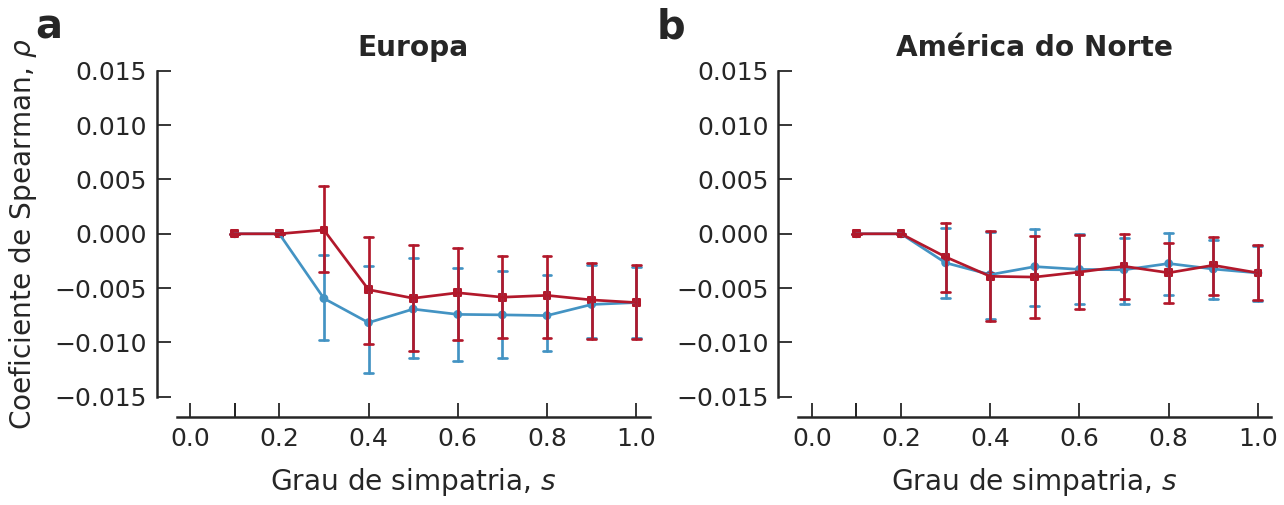

In [707]:
fig, ax = plt.subplots(1, 2, figsize=stdfigsize(nx=2, ny=1))

df = violin_data(nm_spearman_europe_gs, order='greater', country='Europe')
sns.pointplot(x="symp", y="mean", data=df, capsize=.2, ax=ax[0], color=color_s[2])


df = violin_data(nm_spearman_europe_ls, order='less', country='Europe')
sns.pointplot(x="symp", y="mean", data=df, capsize=.2, ax=ax[0], color=color_s[-2], markers='s')


df = violin_data(nm_spearman_north_america_gs, order='greater', country='North America')
sns.pointplot(x="symp", y="mean", data=df, capsize=.2, ax=ax[1], color=color_s[2])

df = violin_data(nm_spearman_north_america_ls, order='less', country='North America')
sns.pointplot(x="symp", y="mean", data=df, capsize=.2, ax=ax[1], color=color_s[-2], markers='s')

fig.tight_layout(pad=2)

c = 0
for ax in ax.flat:
    ax.annotate(string.ascii_lowercase[c], xy=(-0.3, 1.1), xycoords='axes fraction', fontsize=40, weight='bold')
    
    for loc, spine in ax.spines.items():
        if loc in ['left', 'bottom']:
            spine.set_position(('outward', 20)) # outward by 20 points
        elif loc in ['right','top']:
            spine.set_color('none') # don't draw spine
        else:
            raise ValueError('unknown spine location: %s'%loc)
    
    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    if c == 0:
#         ax.legend(['overlap $\\geq 1-s$', 'overlap $\\leq s$'], fontsize=20, frameon=False)

#         ax.set_ylabel('Spearman coefficient, $\\rho$')
        ax.set_ylabel('Coeficiente de Spearman, $\\rho$') # PT
        
    else:
        ax.set_ylabel('')
        
#     ax.set_xlabel('Degree of sympatry, $s$')
#     ax.set_title(['Europe', 'North America'][c])
    ax.set_xlabel('Grau de simpatria, $s$') # PT
    ax.set_title(['Europa', 'América do Norte'][c], weight='bold') # PT
    
    ax.set_ylim(-0.015, 0.015)
    
    ax.set_xlim([-1.3,9.3])
    ax.set_xticks([n if n % 2 != 0 else 0 for n in range(-2,11)])
    ax.set_xticklabels([(n+1)/10 if n % 2 != 0 else '' for n in range(-2,11)])
    
    c += 1
    
fig.tight_layout(pad=2)
# fig.savefig('figures/nm_range_corr_shuffle_bar.pdf', bbox_inches='tight')
# fig.savefig('figures/nm_range_corr_shuffle_bar.png', bbox_inches='tight')
fig.savefig('figures/nm_range_corr_shuffle_bar_pt.pdf', bbox_inches='tight') 

In [683]:
[n if n % 2 != 0 and n > 0else 0 for n in range(-2,11)]

[0, 0, 0, 1, 0, 3, 0, 5, 0, 7, 0, 9, 0]

In [671]:
[(n+1)/10 if n % 2 != 0 else '' for n in range(-1,11)]

[0.0, '', 0.2, '', 0.4, '', 0.6, '', 0.8, '', 1.0, '']

In [500]:
np.arange(0,11,2)

array([ 0,  2,  4,  6,  8, 10])

/home/dsvieira/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


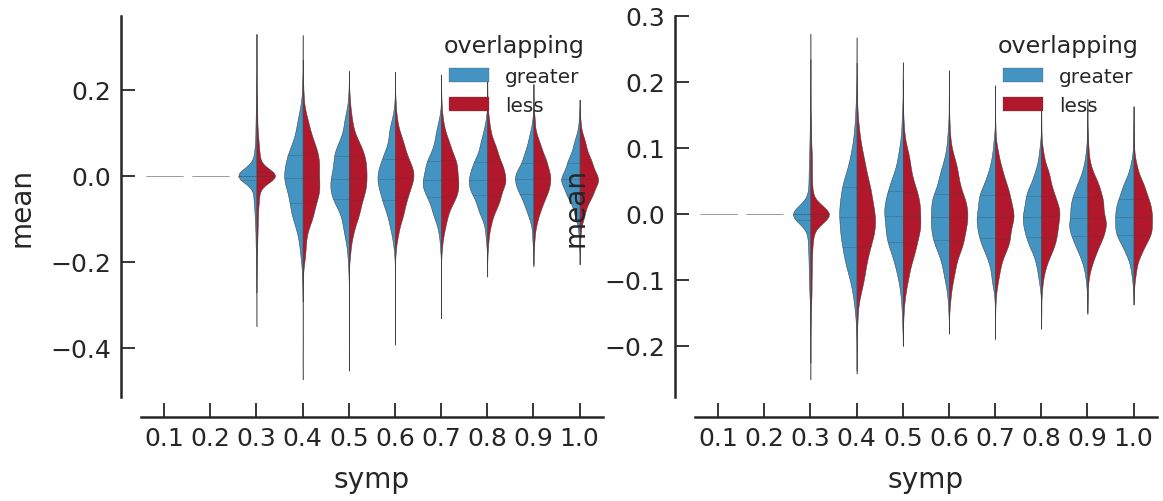

In [388]:
fig, ax = plt.subplots(1, 2, figsize=stdfigsize(ny=1, nx=2))

color_s = palettable.colorbrewer.diverging.RdBu_11_r.mpl_colors

df = pd.concat([violin_data(nm_spearman_europe_gs, order='greater', country='Europe'), violin_data(nm_spearman_europe_ls, order='less', country='Europe')])
sns.violinplot(x='symp', y='mean', hue='overlapping', data=df, palette=[color_s[2], color_s[-2]], split=True, ax=ax[0], inner='quartile', saturation=1, linewidth=0.5)

df = pd.concat([violin_data(nm_spearman_north_america_gs, order='greater', country='North America'), violin_data(nm_spearman_north_america_ls, order='less', country='North America')])
sns.violinplot(x='symp', y='mean', hue='overlapping', data=df, palette=[color_s[2], color_s[-2]], split=True, ax=ax[1], inner='quartile', saturation=1, linewidth=0.5)

for ax in fig.get_axes():
    for loc, spine in ax.spines.items():
        if loc in ['left', 'bottom']:
            spine.set_position(('outward', 20)) # outward by 20 points
        elif loc in ['right','top']:
            spine.set_color('none') # don't draw spine
        else:
            raise ValueError('unknown spine location: %s'%loc)

        # Only show ticks on the left and bottom spines
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')

/home/dsvieira/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


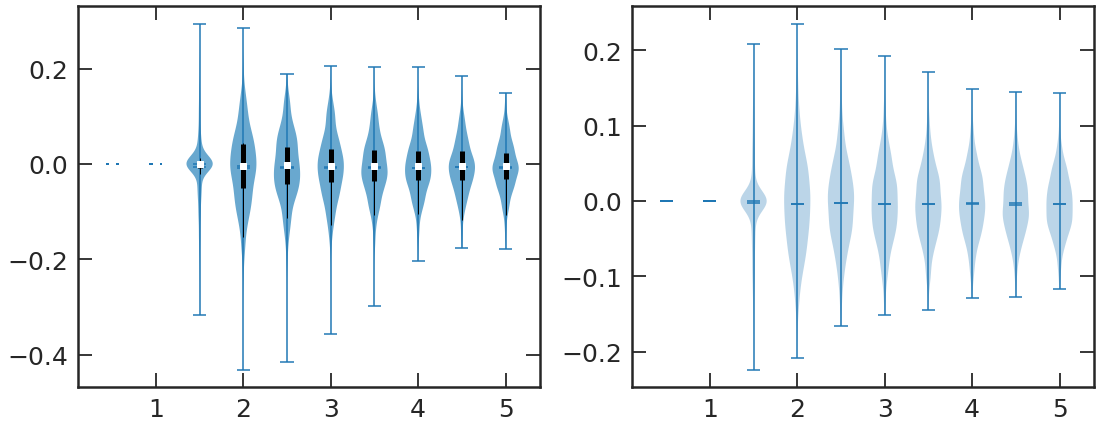

In [412]:
fig, ax = plt.subplots(1, 2, figsize=stdfigsize(nx=2, ny=1))

def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

df = pd.concat([violin_data(nm_spearman_europe_gs, order='greater', country='Europe'), violin_data(nm_spearman_europe_ls, order='less', country='Europe')])
data = [np.asarray(df[(df['overlapping'] == 'greater') & (df['symp'] == s)]['mean']) for s in df['symp'].unique()]
pos  = [s*5 for s in df['symp'].unique()] 

europe_violin = ax[0].violinplot(data, pos, points=1000, widths=0.3, showmeans=True, showextrema=True, showmedians=True)

df = pd.concat([violin_data(nm_spearman_north_america_gs, order='greater', country='North America'), violin_data(nm_spearman_north_america_ls, order='less', country='North America')])
data = [np.asarray(df[(df['overlapping'] == 'greater') & (df['symp'] == s)]['mean']) for s in df['symp'].unique()]
pos  = [s*5 for s in df['symp'].unique()] 

north_america_violin = ax[1].violinplot(data, pos, points=1000, widths=0.3, showmeans=True, showextrema=True, showmedians=True)

for pc in europe_violin['bodies']:
    pc.set_facecolor(color_s[2])
    pc.set_edgecolor(None)
    pc.set_alpha(0.8)
    
quartile1, medians, quartile3 = np.percentile(data, [25, 50, 75], axis=1)
whiskers = np.array([
    adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
whiskersMin, whiskersMax = whiskers[:, 0], whiskers[:, 1]

inds = pos
ax[0].scatter(inds, medians, marker='s', color='white', s=30, zorder=3)
ax[0].vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
ax[0].vlines(inds, whiskersMin, whiskersMax, color='k', linestyle='-', lw=1)